In [1]:
import glob
import os
import pickle
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from scripts.gifMaker import make_gif_from_array
from src.common import as_intrinsics_matrix
from torch.utils.data import Dataset
import threading
from tqdm import tqdm
from src.utils.datasets import get_dataset
import time

import torch.multiprocessing as mp
from src.utils import backproject, create_instance_seg, id_generation, vis
import argparse
from src.NICE_SLAM import NICE_SLAM
from src import config
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
parser = argparse.ArgumentParser(
description="Arguments for running the NICE-SLAM/iMAP*."
)
parser.add_argument("config", type=str, help="Path to config file.")
parser.add_argument(
    "--input_folder",
    type=str,
    help="input folder, this have higher priority, can overwrite the one in config file",
)
parser.add_argument(
    "--output",
    type=str,
    help="output folder, this have higher priority, can overwrite the one in config file",
)
nice_parser = parser.add_mutually_exclusive_group(required=False)
nice_parser.add_argument("--nice", dest="nice", action="store_true")
nice_parser.add_argument("--imap", dest="nice", action="store_false")
parser.set_defaults(nice=True)
args = parser.parse_args(args=['/home/rozenberszki/project/wsnsl/configs/Own/room0_panoptic.yaml'])
#args = parser.parse_args(args=['/home/rozenberszki/project/wsnsl/configs/Own/room0.yaml'])

cfg = config.load_config(  # J:changed it to use our config file including semantics
        args.config, "configs/nice_slam_sem.yaml" if args.nice else "configs/imap.yaml"
    )
slam = NICE_SLAM(cfg, args)
frame_reader = get_dataset(cfg, args, cfg["scale"], slam = slam)
frame_reader.__post_init__(slam)
zero_pos = frame_reader.poses[0]
zero_pos

INFO: The output folder is output/Own/room0_panoptic
INFO: The GT, generated and residual depth/color images can be found under output/Own/room0_panoptic/mapping_vis/
INFO: The mesh can be found under output/Own/room0_panoptic/mesh/
INFO: The checkpoint can be found under output/Own/room0_panoptic/ckpt/


tensor([[-0.3837, -0.0573, -0.9217,  1.8172],
        [-0.9234,  0.0238,  0.3830,  2.1154],
        [-0.0000,  0.9981, -0.0621, -0.4463],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [5]:
class Segmenter(object):

    def __init__(self, slam, cfg, args, zero_pos, store_directory):
        self.store_directory = store_directory
        self.zero_pos = zero_pos
        os.makedirs(f"{store_directory}", exist_ok=True)

        s = torch.ones((4, 4)).int()
        if cfg["dataset"] == "tumrgbd":
            #s[[0, 0, 1, 2], [0, 1, 2, 2]] *= -1
            s[[0, 0, 1, 1, 2], [1, 2, 0, 3, 3]] *= -1
        if cfg["dataset"] == "replica" or cfg["dataset"] == 'panoptic':
            print('shift')
            s[[0, 0, 1, 1, 2], [1, 2, 0, 3, 3]] *= -1
        self.shift = s.numpy()  # s
        self.is_full_slam = cfg["Segmenter"]["full_slam"]
        self.store_vis = cfg["Segmenter"]["store_vis"]
        self.use_stored = cfg["Segmenter"]["use_stored"]
        self.first_min_area = cfg["mapping"]["first_min_area"]

        """path_to_traj = cfg["data"]["input_folder"] + "/traj.txt"
        self.T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)
        self.T_wc[:, 1:3] *= -1"""

        self.every_frame = cfg["mapping"]["every_frame"]
        # self.slam = slam
        self.id_counter = slam.id_counter
        self.idx_mapper = slam.mapping_idx
        #self.estimate_c2w_list = slam.estimate_c2w_list
        #self.idx_coarse_mapper = slam.idx_coarse_mapper

        self.every_frame_seg = cfg["Segmenter"]["every_frame"]
        self.points_per_instance = cfg["mapping"]["points_per_instance"]
        '''self.H, self.W, self.fx, self.fy, self.cx, self.cy = (
            slam.H, slam.W, slam.fx, slam.fy, slam.cx, slam.cy
        )'''
        self.H, self.W, self.fx, self.fy, self.cx, self.cy = (
            cfg["cam"]["H"],
            cfg["cam"]["W"],
            cfg["cam"]["fx"],
            cfg["cam"]["fy"],
            cfg["cam"]["cx"],
            cfg["cam"]["cy"],
        )
        self.cfg = cfg
        self.update_cam()
        self.K = as_intrinsics_matrix([self.fx, self.fy, self.cx, self.cy])
        
        if args is None or args.input_folder is None:
            self.input_folder = cfg["data"]["input_folder"]
        else:
            self.input_folder = args.input_folder
        #self.color_paths = sorted(glob.glob(f"{self.input_folder}/results/frame*.jpg"))
        # self.depth_paths = sorted(glob.glob(f"{self.input_folder}/results/depth*.png"))
        self.frame_reader = get_dataset(
            cfg,
            args,
            cfg["scale"],
            device=cfg["mapping"]["device"],
            tracker=False,
            slam=slam,
        )
        self.estimate_c2w_list = np.concatenate([p[None] for p in self.frame_reader.poses], axis=0)
        """for i in range(len(self.estimate_c2w_list)):
            self.estimate_c2w_list[i, :3,:3] = self.estimate_c2w_list[i, :3,:3].T 
            self.estimate_c2w_list[i, :3, 3] = np.matmul(-self.estimate_c2w_list[i, :3,:3], self.estimate_c2w_list[i, :3, 3])
        print(self.estimate_c2w_list.shape)"""
        print(self.estimate_c2w_list.shape)
        print(f'est list: {self.estimate_c2w_list[0]}')
        self.n_img = self.frame_reader.n_img
        self.semantic_frames = slam.semantic_frames
        self.idx_segmenter = slam.idx_segmenter
        if not self.is_full_slam:
            self.idx = torch.tensor([self.n_img])
        else:
            self.idx = slam.idx  # Tracking index
            # Segmenter index
        # self.new_id = 0
        self.visualizer = vis.visualizerForIds()
        self.frame_numbers = []
        self.samples = None
        self.deleted = {}
        self.border = 0 
        '''(
            cfg["cam"]["crop_edge"]
            if "crop_edge" in cfg["cam"]
            else cfg["Segmenter"]["border"]
        )'''
        self.num_clusters = cfg["Segmenter"]["num_clusters"]
        self.overlap = cfg["Segmenter"]["overlap"]
        self.relevant = cfg["Segmenter"]["relevant"]
        self.max_id = 0
        self.update = {}
        self.verbose = cfg["Segmenter"]["verbose"]
        self.merging_parameter = cfg["Segmenter"]["merging_parameter"]
        self.hit_percent = cfg["Segmenter"]["hit_percent"]

    def update_cam(self):
        """
        Update the camera intrinsics according to pre-processing config,
        such as resize or edge crop.
        """
        # resize the input images to crop_size (variable name used in lietorch)
        if "crop_size" in self.cfg["cam"]:
            crop_size = self.cfg["cam"]["crop_size"]
            sx = crop_size[1] / self.W
            sy = crop_size[0] / self.H
            self.fx = sx * self.fx
            self.fy = sy * self.fy
            self.cx = sx * self.cx
            self.cy = sy * self.cy
            self.W = crop_size[1]
            self.H = crop_size[0]

        # croping will change H, W, cx, cy, so need to change here
        if self.cfg["cam"]["crop_edge"] > 0:
            self.H -= self.cfg["cam"]["crop_edge"] * 2
            self.W -= self.cfg["cam"]["crop_edge"] * 2
            self.cx -= self.cfg["cam"]["crop_edge"]
            self.cy -= self.cfg["cam"]["crop_edge"]

    def segment_idx_forAuto(self, idx):
        """img = cv2.imread(self.color_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)"""
        img, depth = self.frame_reader.get_colorAndDepth(idx)
        #gt_color_np = np.clip(img.cpu().numpy(), 0, 1)
        """plt.imshow(gt_color_np)
        plt.title(f'color {idx}')
        plt.show()"""
        img = (img.cpu().numpy() * 255).astype(np.uint8)
        masksCreated, s, max_id = id_generation.createFrontMappingAutosort(
            idx,
            self.estimate_c2w_list*self.shift,
            self.K,
            depth.cpu(),
            self.predictor,
            max_id=self.max_id,
            current_frame=img,
            samples=self.samples,
            smallesMaskSize=1000,
            border=self.border
        )
        #s[2] *= -1
        self.samples = s
        self.max_id = max_id

        frame = torch.from_numpy(masksCreated)
        self.semantic_frames[idx // self.every_frame_seg] = frame
        return frame

    def segment_first_ForAuto(self):
        """color_path = self.color_paths[0]
        color_data = cv2.imread(color_path)
        image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)"""
        image, depth = self.frame_reader.get_colorAndDepth(0)
        sns.histplot(depth.cpu().numpy().reshape(-1), bins=100)
        plt.title('depth 0')
        plt.show()
        image = (image.cpu().numpy() * 255).astype(np.uint8)
        sam = create_instance_seg.create_sam_forauto("cuda")
        masks = sam.generate(image)
        del sam
        torch.cuda.empty_cache()

        ids = backproject.generateIds_Auto(masks,depth.cpu(), min_area=self.first_min_area)
        # visualizerForId = vis.visualizerForIds()
        # visualizerForId.visualize(ids, f'{self.store_directory}/first_segmentation.png')
        ids[depth.cpu() == 0] = -100
        self.semantic_frames[0] = torch.from_numpy(ids)
        self.frame_numbers.append(0)
        self.max_id = ids.max() + 1
        
        samplesFromCurrent = backproject.sample_from_instances_with_ids_area(
            ids, self.max_id, points_per_instance=500
        )
        realWorldSamples = backproject.realWorldProject(
            samplesFromCurrent[:2, :],
            self.zero_pos*self.shift,
            self.K,
            depth.cpu(),
        )
        realWorldSamples = np.concatenate(
            (realWorldSamples, samplesFromCurrent[2:, :]), axis=0
        )
        return realWorldSamples

    def runAuto(self, max=-1):
        visualizerForId = vis.visualizerForIds()

        print("segment first frame")
        s = self.segment_first_ForAuto()
        #print("finished segmenting first frame")
        visualizerForId.visualize(self.semantic_frames[0], path = 'test/00_after.png')
        im = visualizerForId.visualize(self.semantic_frames[0])
        plt.show()
        if self.is_full_slam:
            path = os.path.join(self.store_directory, f"seg_{0}.npy")
            # np.save(path, self.semantic_frames[0].numpy())
            self.idx_segmenter[0] = 0
        #s[2] *= -1
        self.samples = s
        #self.samples = np.array([[0,0,1],[0,1,0],[1,0,0], [0,0,0]])
        print(np.unique(self.samples[3], return_counts=True))
        self.predictor = create_instance_seg.create_sam_forauto("cuda")
   
        index_frames = np.arange(
            self.every_frame_seg, self.n_img, self.every_frame_seg
        )
          
        self.plot()
        for idx in index_frames: #tqdm(index_frames, desc="Segmenting frames"):
            if idx == 200:
                #self.plot_mesh()
                return
            #print("start segmenting frame: ", idx)
            start = time.time()
            self.segment_idx_forAuto(idx)
            print(f'time: {time.time()-start}')
            print(np.unique(self.samples[3], return_counts=True))
            frame = self.semantic_frames[idx // self.every_frame_seg]
            #print("finished segmenting frame: ", idx)
            #fig, ax = plt.subplots(1)

            visualizerForId.visualize(
                frame.cpu().numpy()
            )
            plt.title(f"frame: {idx}")
            #ax[1].imshow(self.frame_reader.get_colorAndDepth(idx)[1].cpu().numpy())
            plt.show()
            self.plot()
            """_,depth= frame_reader.get_colorAndDepth(idx)
            sns.heatmap(depth.cpu().numpy() == 0)
            plt.show()"""
            # print(f'outside samples: {np.unique(self.samples[-1])}')
        if self.n_img - 1 % self.every_frame_seg != 0:
            _ = self.segment_idx_forAuto(self.n_img - 1)


        return self.semantic_frames, self.max_id + 1
    
    def plot_mesh(self):
        import open3d as o3d
        data = self.samples.copy()[:3].T
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(data)
        pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

        # Step 2: Compute a mesh using the Ball Pivoting algorithm
        # You may need to adjust the radii parameter based on the scale of your point cloud
        radii = [1,1,1,1]
        mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
            pcd, o3d.utility.DoubleVector(radii))

        # Step 3: Simplify the mesh (optional, if you need to reduce the complexity)
        mesh_simplified = mesh.simplify_quadric_decimation(target_number_of_triangles=1000)
        o3d.io.write_triangle_mesh("test_mesh.obj", mesh_simplified)

        plt.show()
    
    def plot(self):
        data = self.samples.copy()
        #data = data[:, data[1] > -2]
        data = self.samples.copy()
        #data = data[:, data[1] > -2]
        x = data[0]
        y = data[1]
        z = data[2] * -1
        labels = data[3]

        # Create a scatter plot
        fig = plt.figure()
        fig.set_size_inches(18.5, 10.5)
        ax = fig.add_subplot(111, projection="3d")
        ax = fig.add_subplot(111, projection="3d")

        # Plot each point with a color corresponding to its label
        unique_labels = np.unique(labels)
        for label in unique_labels:
            indices = np.where(labels == label)
            ax.scatter(x[indices], y[indices], z[indices], s=3)

        # Set axis labels
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        #ax.set_ylim((-2, 2))
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        #ax.set_ylim((-2, 2))
        # Add a legend
        ax.legend()

        # Show the plot
        plt.show()
    
    def debugging(self):
        poses = self.estimate_c2w_list
        ff_pos = np.array([[0,1,30,300],[1,0,30,300]])
        print(ff_pos.T)
        depth = frame_reader.get_colorAndDepth(20)[1].cpu()
        ff_rw = backproject.realWorldProject(ff_pos, poses[20], self.K, depth)
        print(ff_rw)
        cam = backproject.camProject(ff_rw, poses[20], self.K)[0].T
        print(cam)
        """rw_pos = np.array([[100,0,0],[0,0,100],[0,100,0]])
        poses = self.estimate_c2w_list
        print(ff_pos)
        
        plt.imshow(depth)
        plt.show()
        ff_rw = backproject.realWorldProject(ff_pos, poses[0], self.K, depth)
        print(ff_rw)
        cam = backproject.camProject(rw_pos, poses[20], self.K)[0].T
        print(cam)
        plt.scatter(cam[:,0], cam[:,1])
        plt.show()"""

In [6]:
frame_reader.get_colorAndDepth(0)[1]

tensor([[2.2230, 2.2240, 2.2260,  ..., 2.1990, 2.1990, 2.2000],
        [2.2310, 2.2330, 2.2340,  ..., 2.2090, 2.2090, 2.2090],
        [2.2470, 2.2490, 2.2500,  ..., 2.2280, 2.2280, 2.2290],
        ...,
        [0.5950, 0.5960, 0.5960,  ..., 1.6030, 1.6020, 1.6020],
        [0.5940, 0.5950, 0.5950,  ..., 1.5950, 1.5940, 1.5940],
        [0.5920, 0.5920, 0.5930,  ..., 1.5810, 1.5810, 1.5800]],
       device='cuda:0')

In [7]:
segmenter = Segmenter(slam, cfg, args, zero_pos, 'test')

shift
(675, 4, 4)
est list: [[-0.3837331  -0.05730035 -0.9216646   1.8172406 ]
 [-0.92344403  0.02381091  0.38299364  2.1153615 ]
 [-0.          0.998073   -0.0620507  -0.44625387]
 [ 0.          0.          0.          1.        ]]


In [8]:
segmenter.debugging()

[[  0   1]
 [  1   0]
 [ 30  30]
 [300 300]]
[[-0.54597501 -0.55720819 -0.86271203 -0.2475952 ]
 [ 4.80141897  4.80674328  4.98868372  2.35354525]
 [-1.53500185 -1.55070845 -1.40709276  1.01342713]]
[[  0   1]
 [  0   0]
 [ 29  30]
 [299 299]]


In [9]:
import os
import shutil

folder_path = '/home/rozenberszki/project/wsnsl/test'

# Check if the folder exists
if os.path.exists(folder_path):
    # Delete the folder and its contents
    shutil.rmtree(folder_path)

# Create the folder
os.makedirs(folder_path)


segment first frame


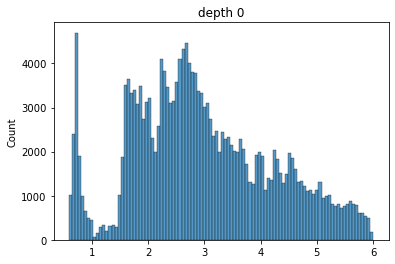

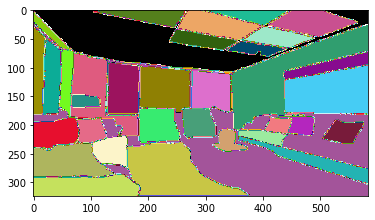

(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34.]), array([942, 591, 463, 411, 270, 250, 243, 242, 185, 182, 180, 175, 163,
       148, 140, 137, 111, 110, 107, 105, 104, 104,  97,  85,  83,  78,
        71,  62,  58,  54,  52,  42,  41,  41]))


No handles with labels found to put in legend.


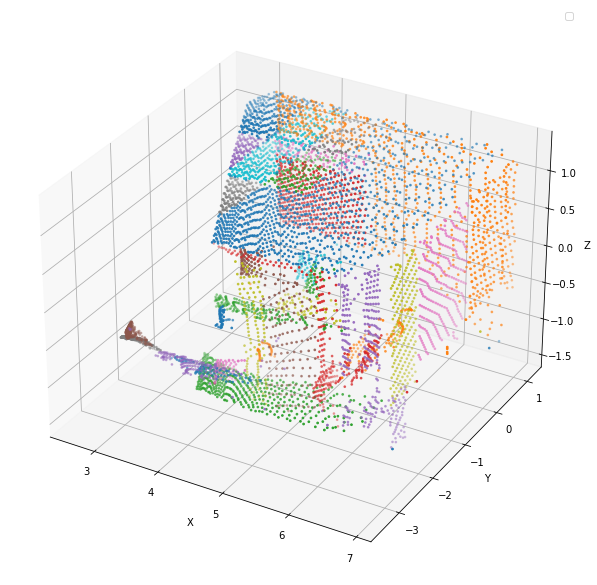

mask generation time:  0.7744081020355225
time: 0.8434875011444092
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41.]), array([1736, 1158, 1729,  844,  270,  452,  479,  639,  353,  303,  282,
        352,  496,  274,  280,  137,  227,  110,  107,  204,  169,  182,
        185,  168,   83,  133,  125,  117,  101,  157,   52,   42,   41,
         41,  290,  176,   83,   65,   65,   62,   41]))


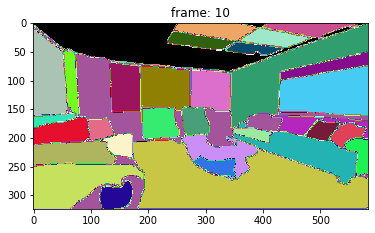

No handles with labels found to put in legend.


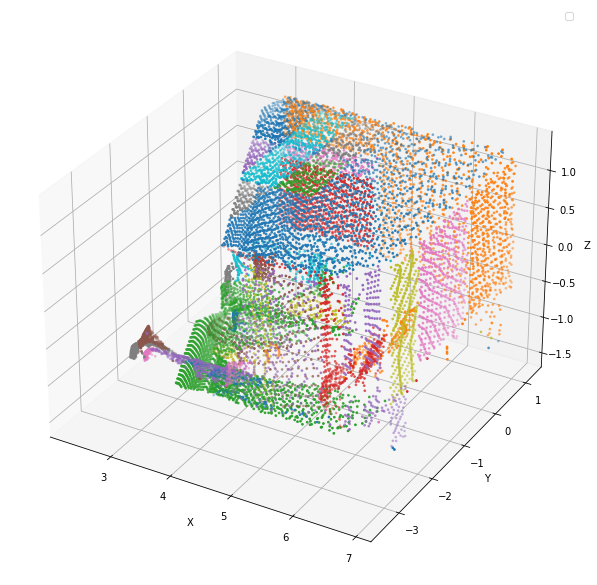

mask generation time:  0.7398006916046143
time: 0.8409063816070557
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44.]), array([2692, 1721, 2948, 1231,  426,  569,  695, 1062,  490,  410,  282,
        534,  925,  380,  491,  137,  330,  110,  107,  204,  235,  182,
        185,  305,   83,  181,  166,  117,  101,  202,   52,   42,   41,
         41,  831,  364,  129,  163,   65,  115,  127,  116,   78,   73]))


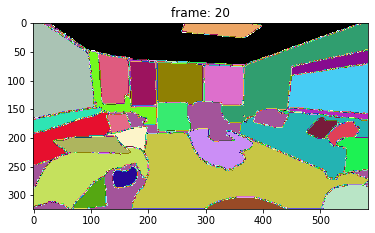

No handles with labels found to put in legend.


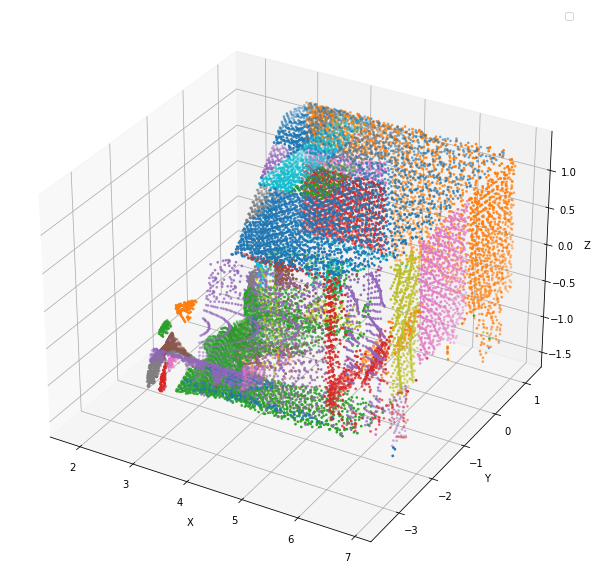

mask generation time:  0.746845006942749
time: 0.8494179248809814
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45.]), array([3825, 2270, 4042, 1559,  426,  637,  889, 1326,  605,  508,  282,
        719, 1063,  473,  570,  137,  416,  110,  107,  204,  301,  248,
        185,  305,   83,  225,  166,  117,  101,  202,   52,   42,   41,
         41, 1619,  530,  129,  286,   65,  167,  252,  242,  175,  118,
        108]))


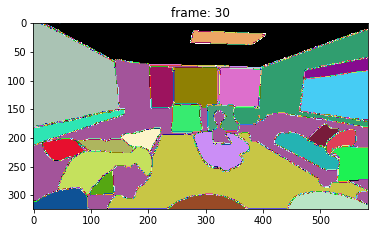

No handles with labels found to put in legend.


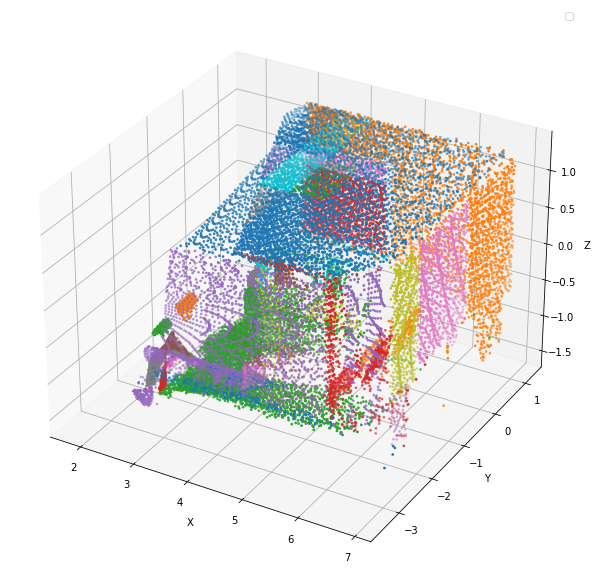

mask generation time:  0.7507224082946777
time: 0.8819899559020996
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45.]), array([5213, 2740, 5104, 1827,  426,  695, 1074, 1534,  704,  587,  282,
        912, 1156,  560,  627,  137,  486,  110,  107,  204,  371,  310,
        185,  305,   83,  271,  166,  117,  101,  299,   52,   42,   41,
         41, 2550,  695,  129,  420,   65,  224,  468,  242,  223,  118,
        219]))


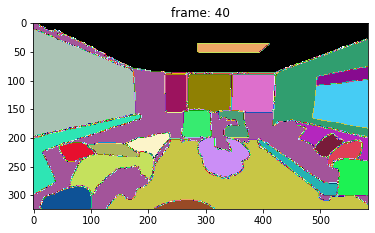

No handles with labels found to put in legend.


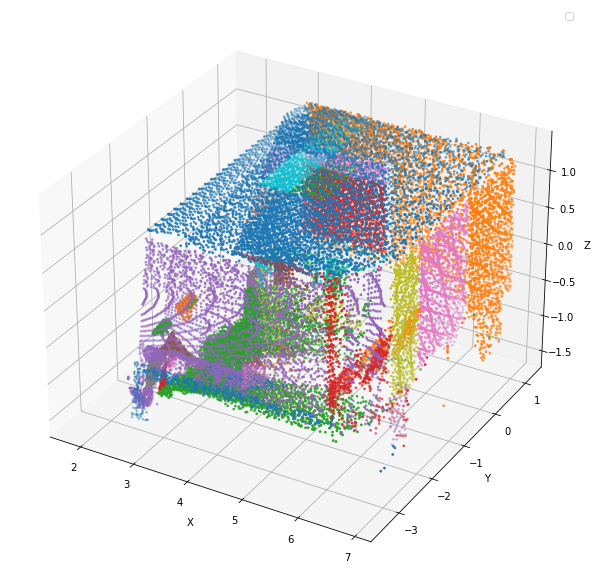

mask generation time:  0.7569057941436768
time: 0.904376745223999
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46.]), array([6713, 3258, 6062, 2023,  549,  750, 1274, 1757,  804,  676,  282,
       1128, 1258,  650,  781,  137,  537,  110,  107,  204,  451,  384,
        185,  365,   83,  328,  166,  117,  101,  387,   52,   42,   83,
         41, 3520,  875,  129,  515,   65,  276,  680,  242,  223,  118,
        322,   56]))


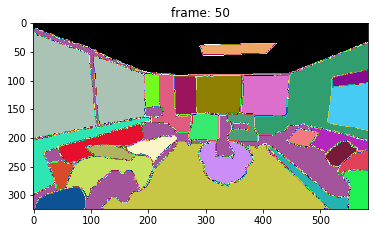

No handles with labels found to put in legend.


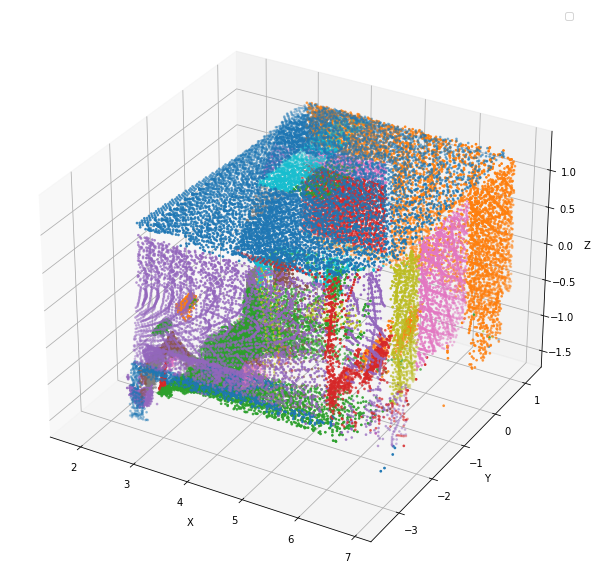

mask generation time:  0.7545797824859619
time: 0.902341365814209
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46.]), array([7586, 3817, 7232, 2185,  762,  821, 1496, 2047,  913,  806,  282,
       1390, 1369,  748,  850,  137,  537,  110,  107,  295,  553,  492,
        260,  365,   83,  404,  166,  117,  143,  478,   52,   42,  137,
         41, 4507, 1095,  129,  515,   65,  276,  789,  242,  223,  118,
        444,   56]))


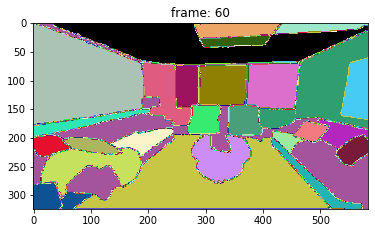

No handles with labels found to put in legend.


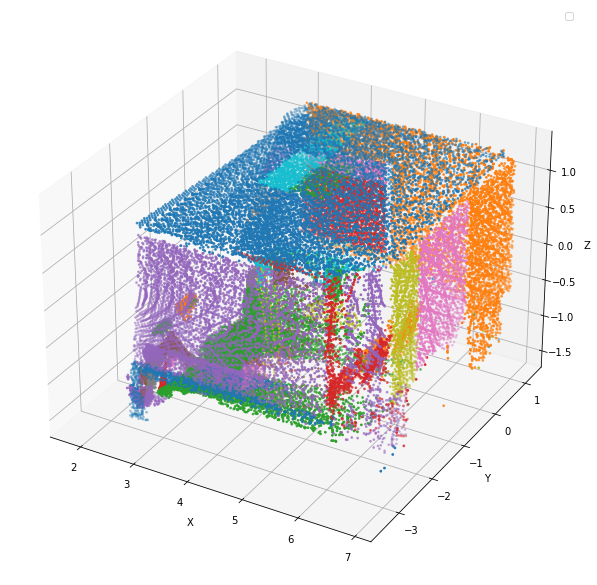

mask generation time:  0.791682243347168
time: 0.936002254486084
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46.]), array([8161, 4381, 8777, 2347,  762,  889, 1748, 2324, 1034,  806,  282,
       1690, 1669,  825,  850,  137,  537,  110,  107,  295,  652,  606,
        260,  365,   83,  485,  166,  117,  143,  578,   52,   42,  194,
         41, 5406, 1304,  129,  684,   65,  341,  875,  242,  339,  118,
        547,   56]))


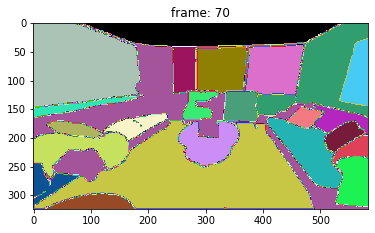

No handles with labels found to put in legend.


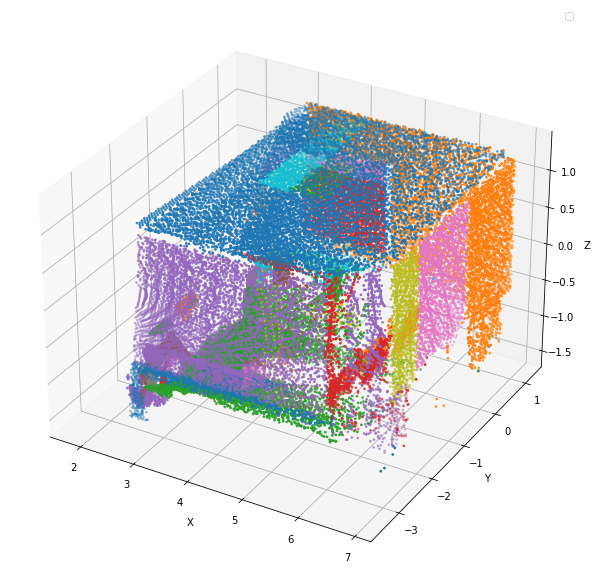

mask generation time:  0.7724165916442871
time: 0.9493119716644287
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46.]), array([ 8654,  4881, 10153,  2546,   970,   936,  1990,  2512,  1144,
         806,   282,  2020,  1944,   896,   935,   137,   537,   110,
         107,   295,   652,   711,   260,   365,    83,   536,   166,
         117,   143,   727,    52,    42,   242,    41,  6350,  1469,
         129,  1007,    65,   431,   968,   391,   719,   118,   715,
          56]))


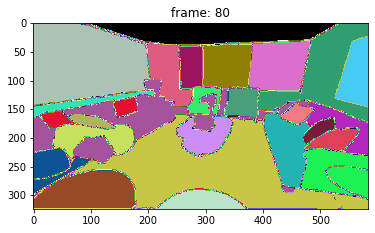

No handles with labels found to put in legend.


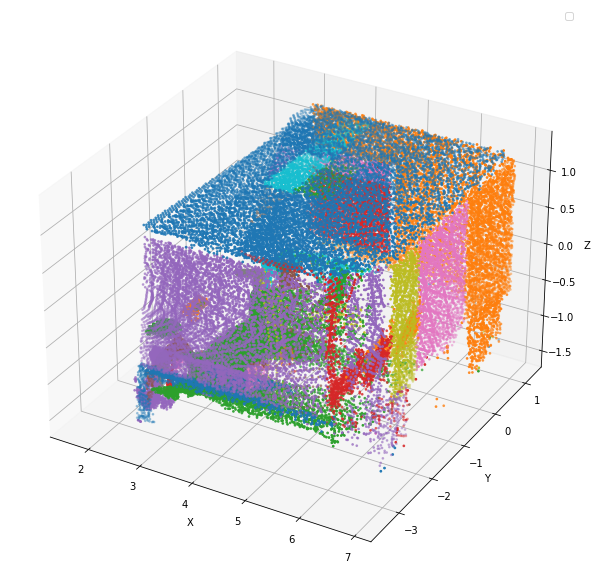

mask generation time:  0.7640471458435059
time: 0.9215869903564453
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46.]), array([ 9654,  5353, 11247,  2623,  1153,   936,  2218,  2664,  1241,
         909,   282,  2327,  2253,   967,  1027,   137,   537,   110,
         107,   295,   696,   818,   260,   365,    83,   592,   166,
         117,   143,   838,    52,    42,   292,    41,  7422,  1624,
         129,  1234,    65,   532,  1236,   391,   905,   118,   958,
          56]))


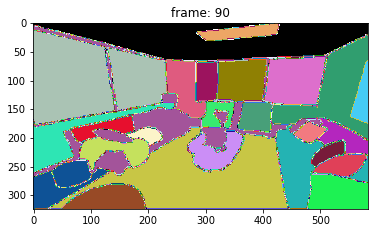

No handles with labels found to put in legend.


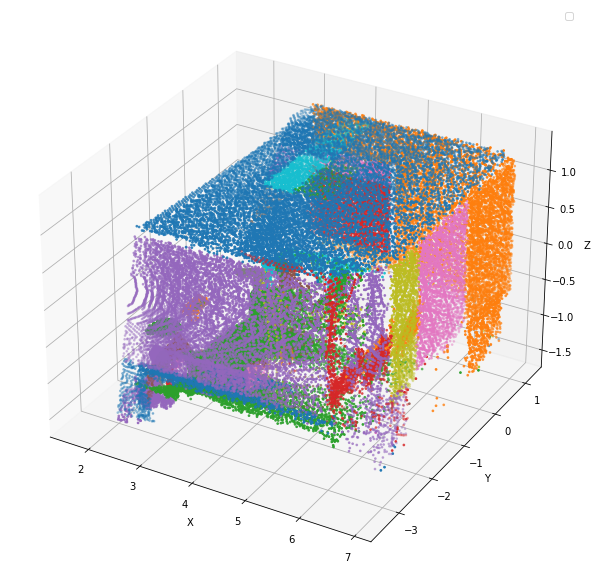

mask generation time:  0.8561766147613525
time: 1.0624480247497559
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46.]), array([11151,  5878, 12057,  2623,  1351,   987,  2461,  2870,  1344,
        1011,   282,  2656,  2545,  1056,  1203,   137,   537,   110,
         107,   295,   804,   943,   260,   365,    83,   696,   166,
         117,   143,   954,    52,    42,   360,    41,  8530,  1859,
         129,  1234,    65,   579,  1475,   391,   905,   118,  1055,
          56]))


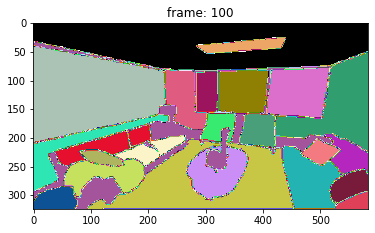

No handles with labels found to put in legend.


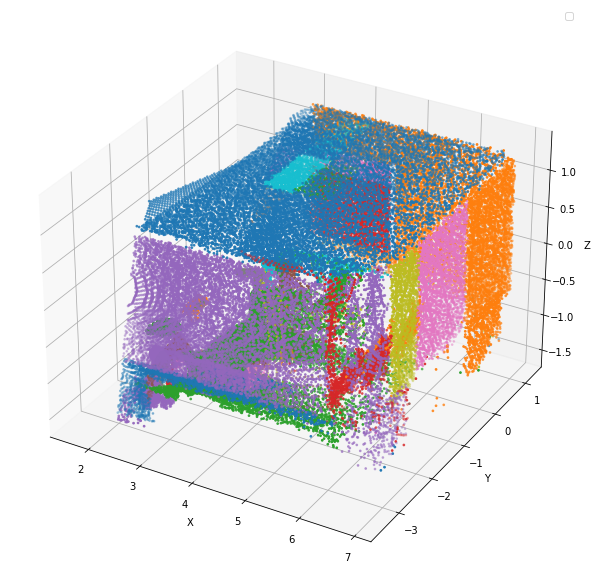

mask generation time:  0.7840685844421387
time: 1.0012595653533936
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46.]), array([12578,  6520, 12425,  2821,  1576,  1062,  2715,  3138,  1454,
        1135,   282,  2967,  3044,  1144,  1397,   137,   537,   110,
         107,   295,   941,  1068,   260,   365,    83,   806,   166,
         117,   143,   954,    52,    42,   426,    41,  9421,  2127,
         129,  1234,    65,   655,  1604,   391,   905,   118,  1055,
          56]))


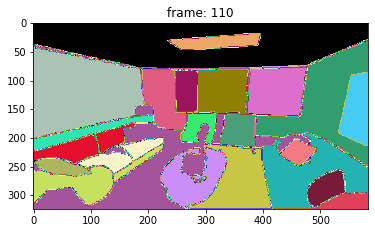

No handles with labels found to put in legend.


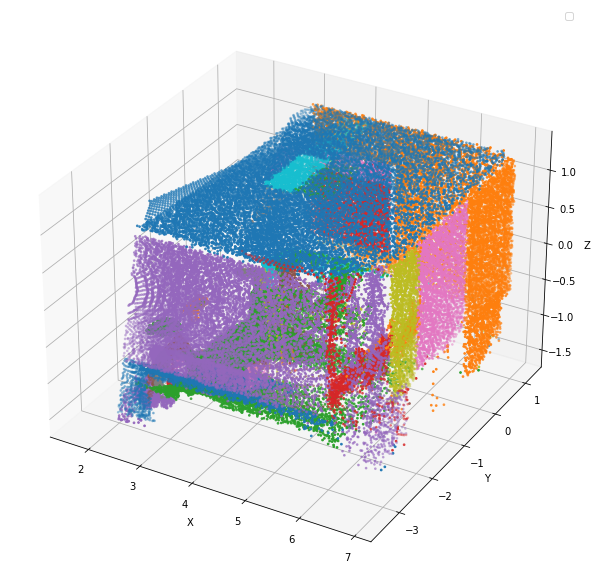

mask generation time:  0.8049860000610352
time: 1.030576229095459
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46.]), array([13246,  7163, 13667,  3017,  1576,  1117,  2991,  3319,  1571,
        1135,   282,  3374,  3405,  1230,  1573,   137,   537,   110,
         107,   295,  1122,  1200,   260,   365,    83,   908,   217,
         117,   143,  1306,    52,    42,   493,    41, 10296,  2359,
         129,  1234,    65,   845,  1705,   391,   905,   118,  1055,
          56]))


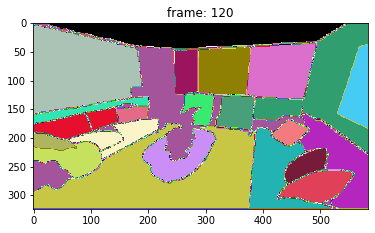

No handles with labels found to put in legend.


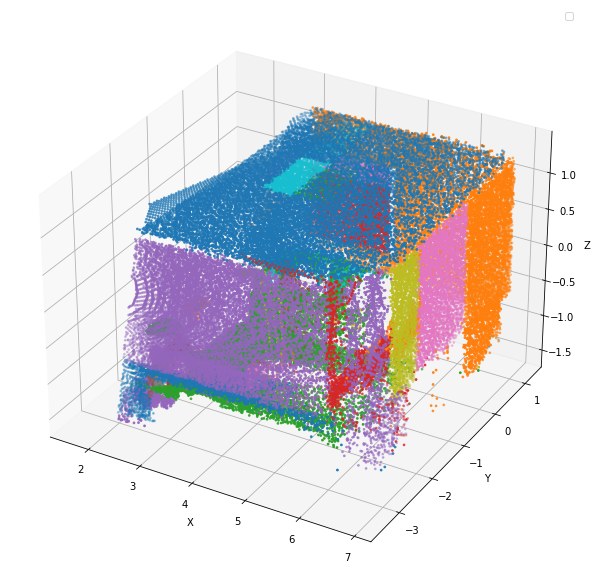

mask generation time:  0.7902352809906006
time: 0.968050479888916
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47.]), array([13246,  7367, 15519,  3017,  1811,  1168,  3308,  3516,  1691,
        1135,   282,  3770,  3876,  1351,  1784,   137,   537,   110,
         107,   295,  1298,  1388,   260,   365,    83,  1078,   217,
         117,   143,  1445,    52,    42,   603,    41, 11094,  2610,
         129,  1358,    65,  1129,  1822,   391,  1066,   118,  1122,
          56,    58]))


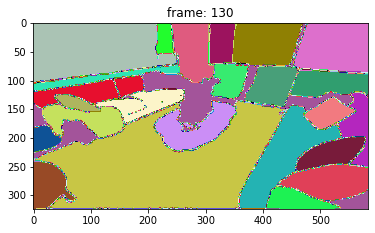

No handles with labels found to put in legend.


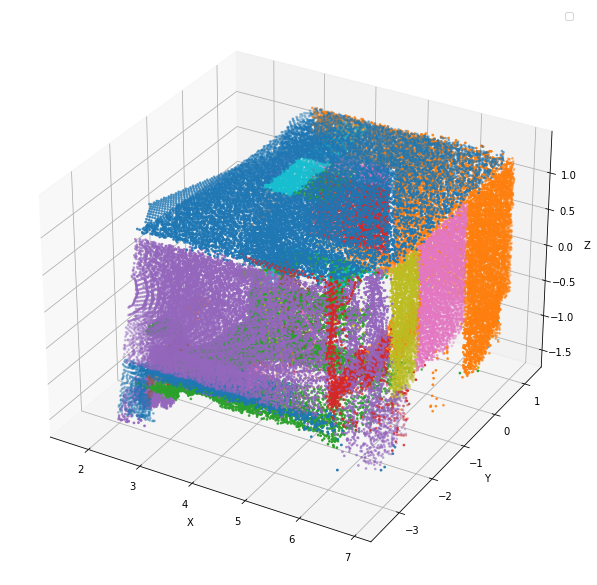

mask generation time:  0.8007116317749023
time: 0.952587366104126
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47.]), array([13246,  7367, 17645,  3017,  2014,  1228,  3584,  3730,  1785,
        1135,   282,  3965,  4605,  1519,  2017,   137,   537,   110,
         107,   295,  1513,  1649,   260,   365,    83,  1353,   217,
         117,   143,  1445,    52,    42,   785,    41, 11755,  2969,
         129,  1358,    65,  1257,  1956,   391,  1109,   118,  1204,
          56,    58]))


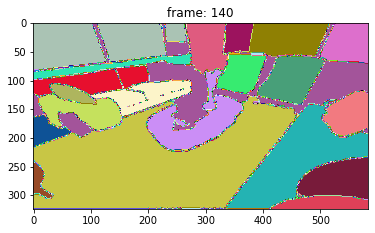

No handles with labels found to put in legend.


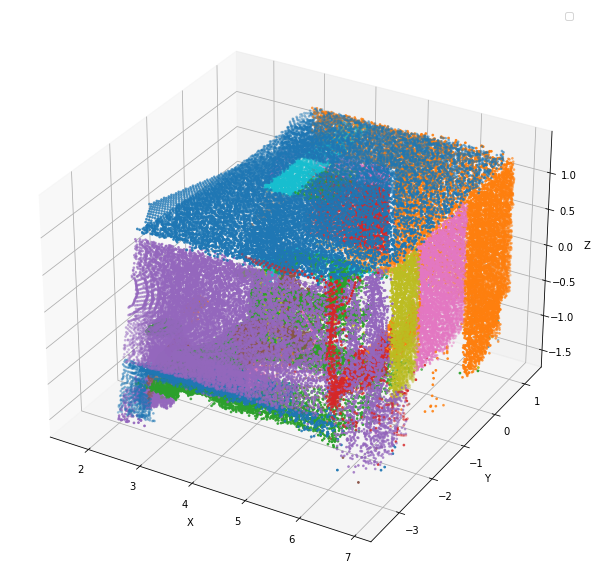

mask generation time:  0.7566313743591309
time: 0.858119010925293
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]), array([13246,  7367, 18739,  3017,  2280,  1228,  4026,  3950,  1930,
        1135,   282,  4521,  5090,  1681,  2245,   137,   537,   110,
         107,   295,  1782,  1896,   260,   365,    83,  1353,   260,
         117,   143,  1445,    98,    42,   993,    41, 12947,  3076,
         129,  1358,    65,  1257,  1956,   391,  1109,   118,  1204,
          56,    58,   412,    42]))


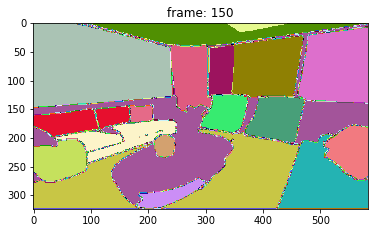

No handles with labels found to put in legend.


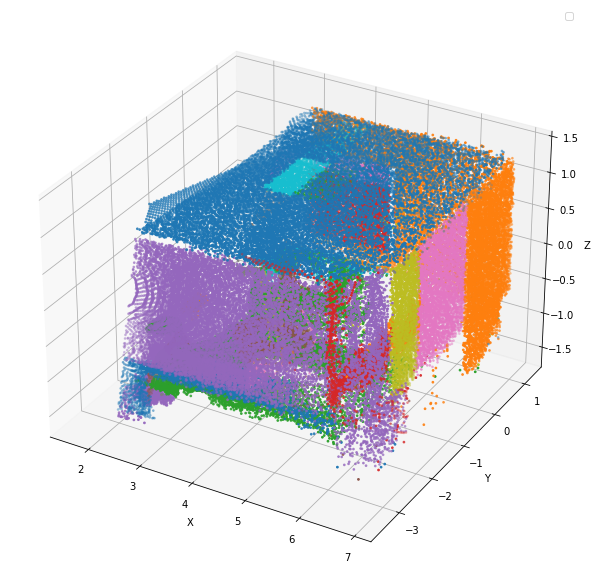

mask generation time:  0.7401866912841797
time: 0.9252536296844482
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]), array([14741,  7413, 19417,  3017,  2514,  1298,  4504,  4338,  2065,
        1135,   282,  4725,  5090,  1866,  2499,   137,   537,   110,
         107,   295,  1919,  2251,   260,   365,    83,  1353,   303,
         117,   143,  1445,   154,    42,   993,    41, 14321,  3657,
         129,  1358,    65,  1257,  1956,   391,  1109,   118,  1204,
          56,    58,   412,    42]))


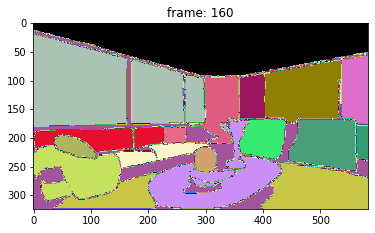

No handles with labels found to put in legend.


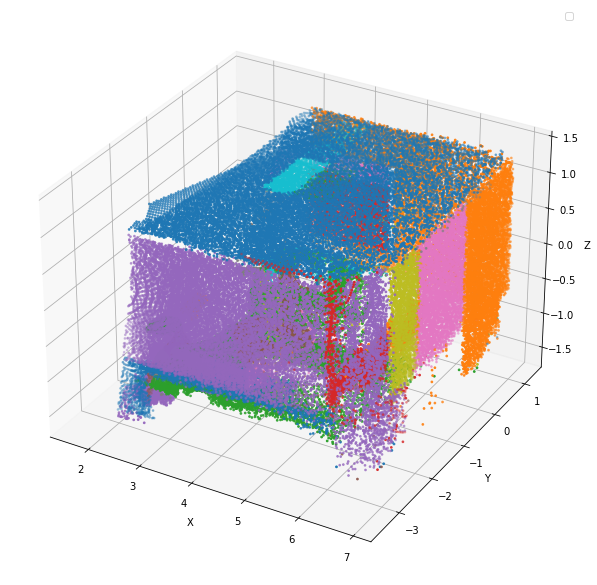

mask generation time:  0.7391345500946045
time: 0.8821306228637695
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]), array([16182,  7413, 19873,  3017,  2801,  1346,  4873,  4606,  2225,
        1135,   282,  4725,  5090,  2005,  2699,   137,   537,   110,
         107,   295,  2142,  2376,   260,   365,    83,  1353,   345,
         117,   143,  1445,   221,    42,   993,    41, 16120,  4276,
         129,  1358,    65,  1257,  2295,   391,  1109,   118,  1429,
          56,    58,   412,    42]))


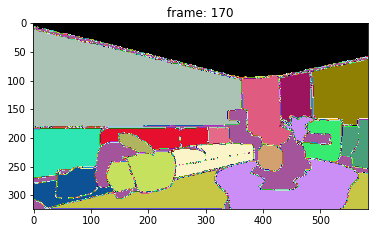

No handles with labels found to put in legend.


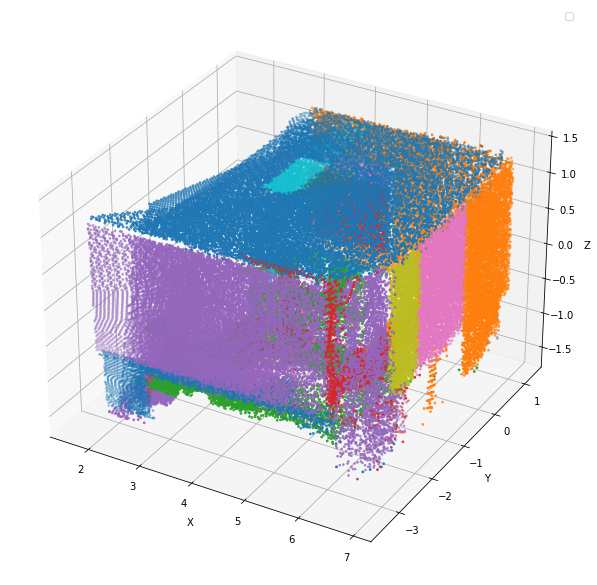

mask generation time:  0.7321245670318604
time: 0.8357298374176025
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.]), array([18208,  7413, 20000,  3017,  3271,  1405,  4873,  4775,  2387,
        1135,   282,  4725,  5090,  2005,  2940,   137,   537,   110,
         107,   295,  2334,  2376,   260,   365,    83,  1353,   406,
         117,   143,  1445,   221,    42,   993,    41, 18349,  4339,
         129,  1358,    65,  1257,  3027,   391,  1109,   118,  1553,
          56,    58,   412,    42,    62,    49]))


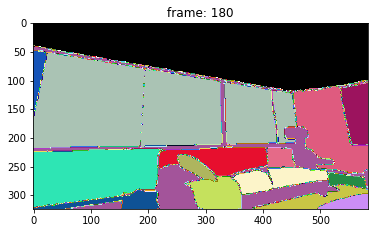

No handles with labels found to put in legend.


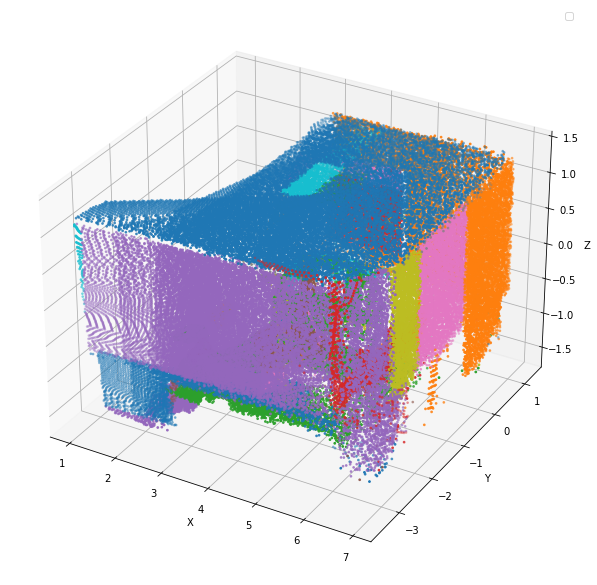

mask generation time:  0.7055196762084961
time: 0.7757856845855713
(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53.]), array([20374,  7413, 20000,  3017,  3271,  1511,  4873,  4892,  2387,
        1135,   282,  4725,  5090,  2005,  3326,   137,   537,   110,
         107,   295,  2482,  2376,   260,   365,    83,  1353,   468,
         117,   143,  1445,   221,    42,   993,    41, 21052,  4339,
         129,  1358,    65,  1257,  4008,   391,  1109,   118,  1553,
          56,    58,   412,    42,    62,    49,   489,    70]))


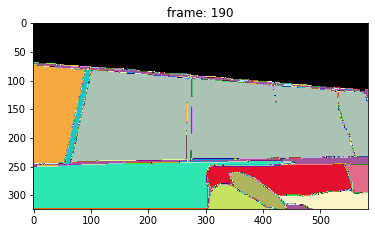

No handles with labels found to put in legend.


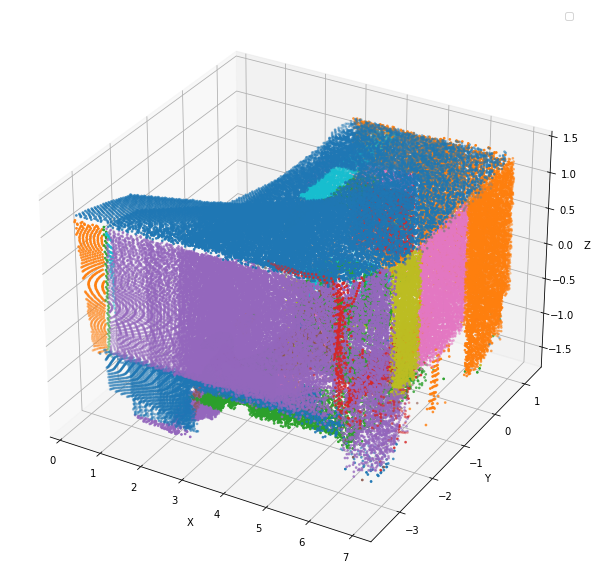

In [10]:
segmenter.runAuto()

In [ ]:
import numpy as np
import open3d as o3d
points = np.random.rand(10,3)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Step 2: Compute a mesh using the Ball Pivoting algorithm
# You may need to adjust the radii parameter based on the scale of your point cloud
radii = [0.005, 0.01, 0.02, 0.04]
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
       pcd, o3d.utility.DoubleVector(radii))

# Step 3: Simplify the mesh (optional, if you need to reduce the complexity)
mesh_simplified = mesh.simplify_quadric_decimation(target_number_of_triangles=1000)
o3d.io.write_triangle_mesh("test_mesh.obj", mesh_simplified)

In [ ]:
frame_reader.n_img//50

48

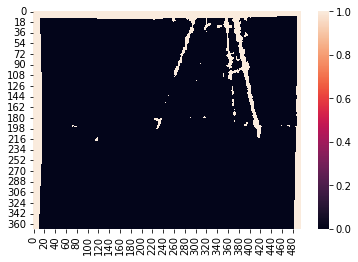

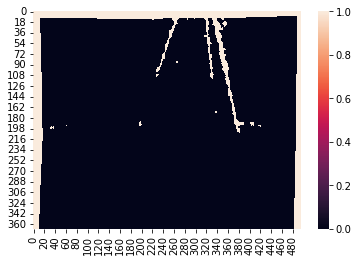

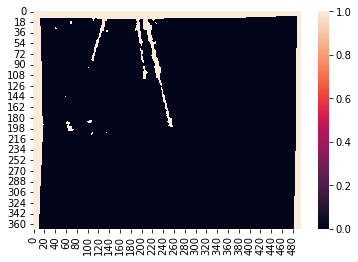

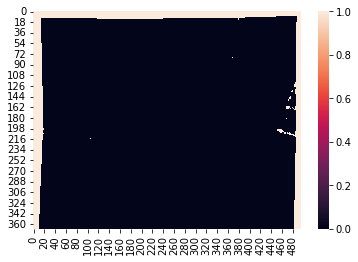

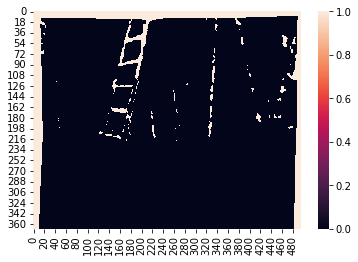

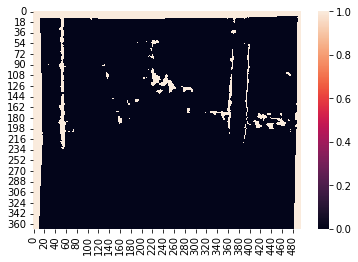

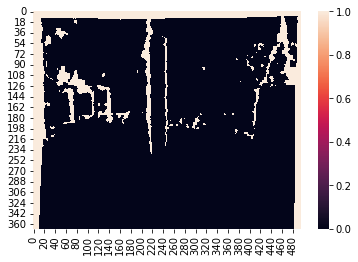

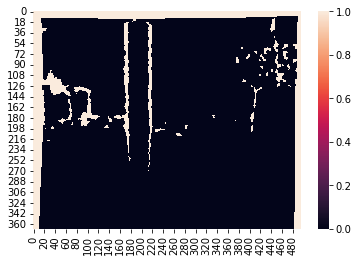

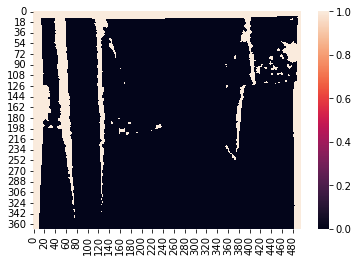

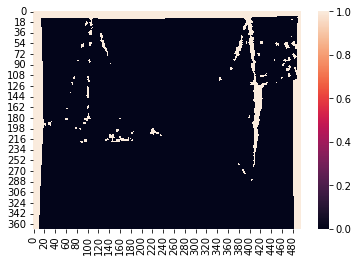

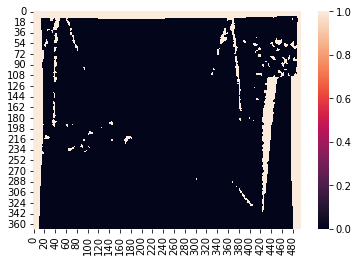

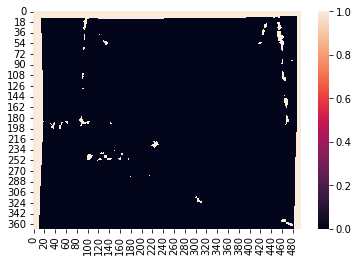

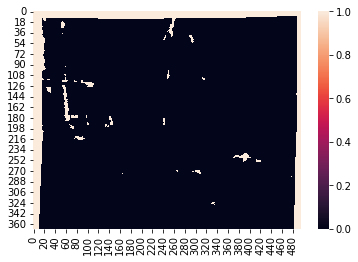

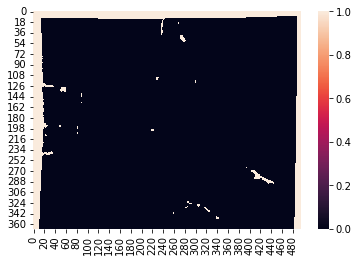

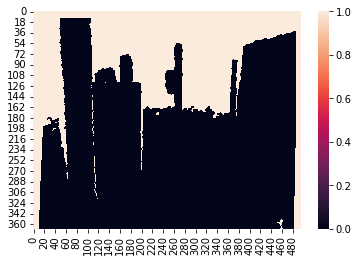

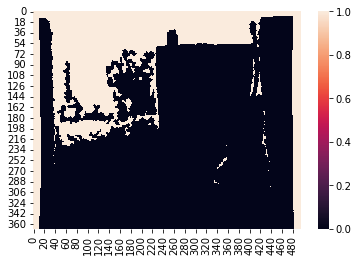

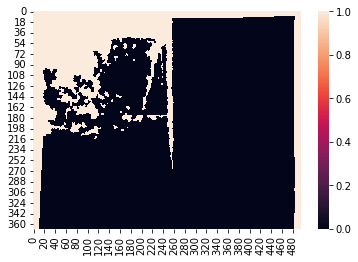

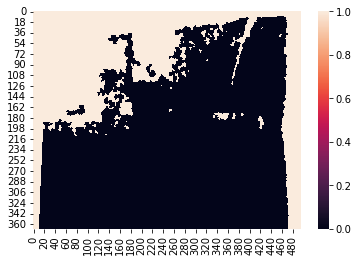

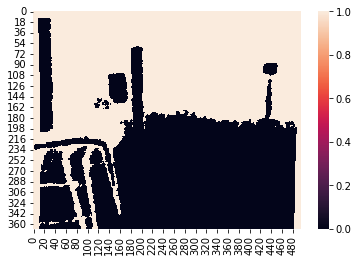

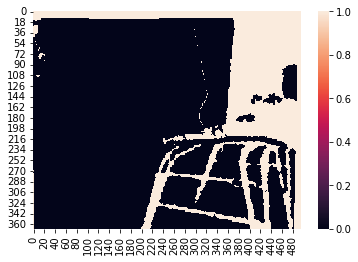

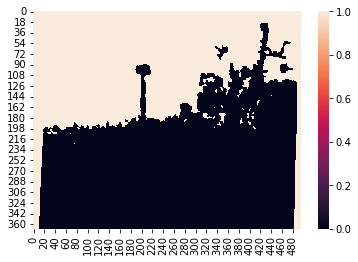

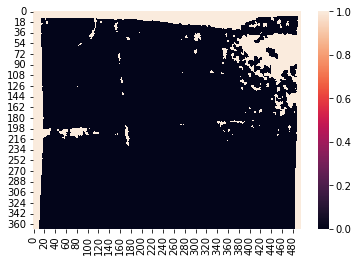

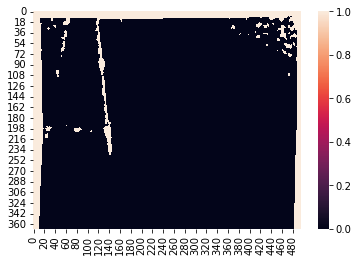

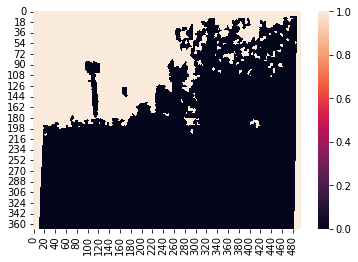

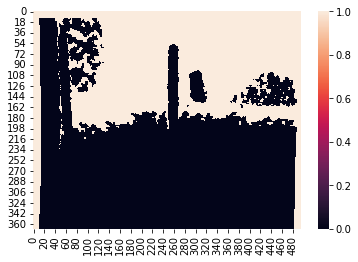

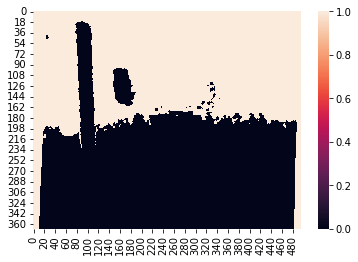

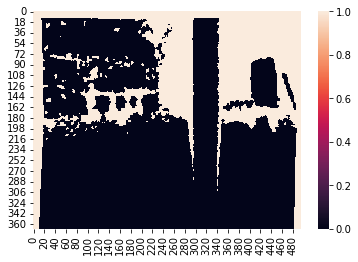

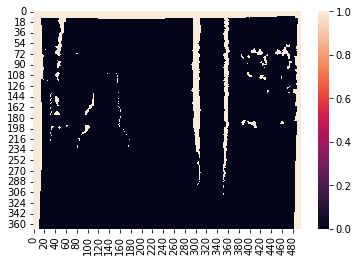

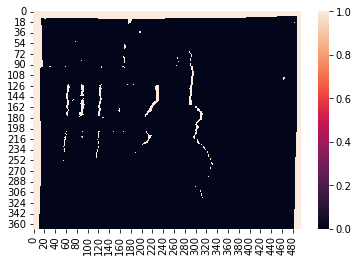

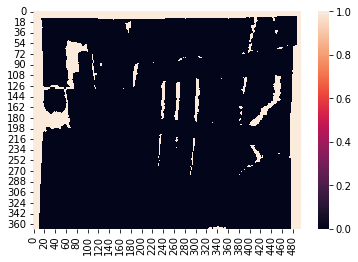

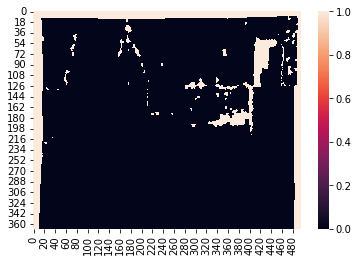

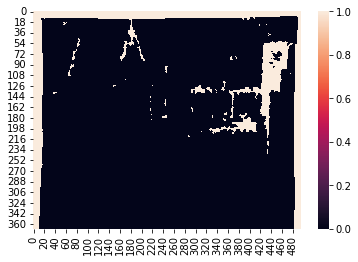

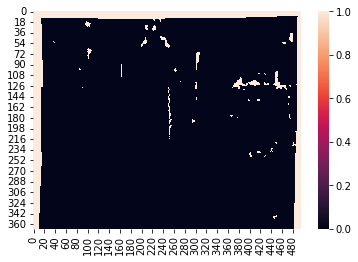

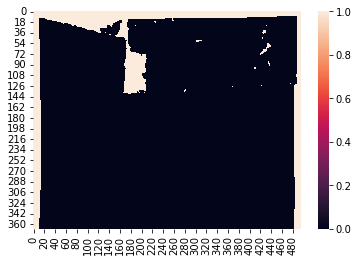

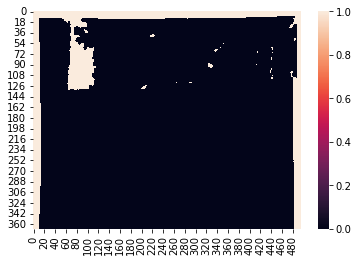

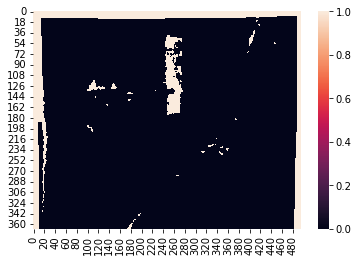

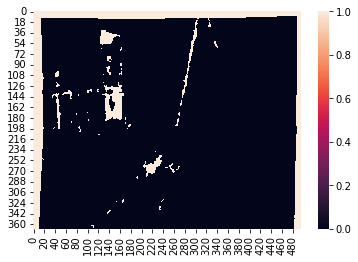

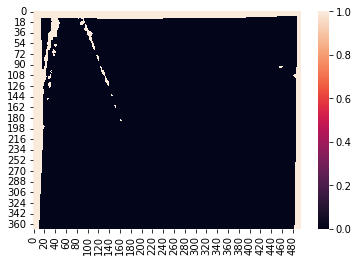

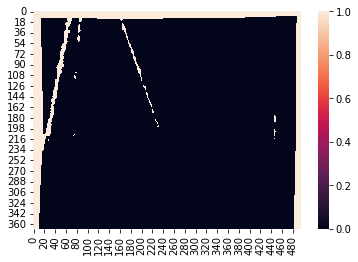

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
for idx in range(0, frame_reader.n_img, 50):
    _,_, depth,_,_ = frame_reader[idx]
    sns.heatmap(depth.cpu().numpy() == 0)
    plt.show()
    plt.clf()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


depth shape: torch.Size([480, 640]), color shape: torch.Size([480, 640, 3])


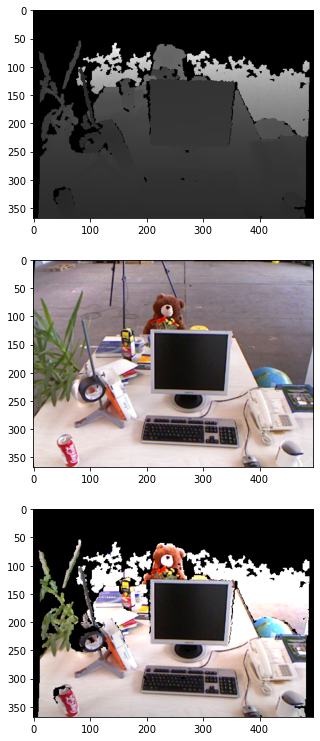

In [10]:
color, depth= frame_reader.get_colorAndDepth(1000)
#_,depth = frame_reader.get_colorAndDepth(80)
color = color.cpu().numpy()
depth = depth.cpu().numpy()
depth = depth / np.max(depth)
depth = np.stack([depth, depth, depth], axis=-1)
fig, ax = plt.subplots(3, 1, figsize=(40, 13))
ax[0].imshow(depth)
#plt.show()
ax[1].imshow(color)
#plt.show()
ax[2].imshow(color*depth*5)